In [1]:
import librosa

array, sampling_rate = librosa.load(librosa.ex("trumpet"))

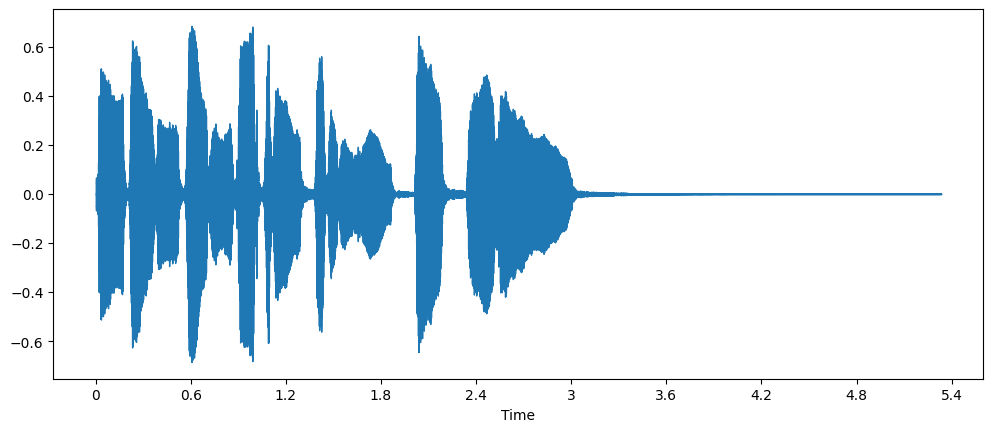

In [2]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

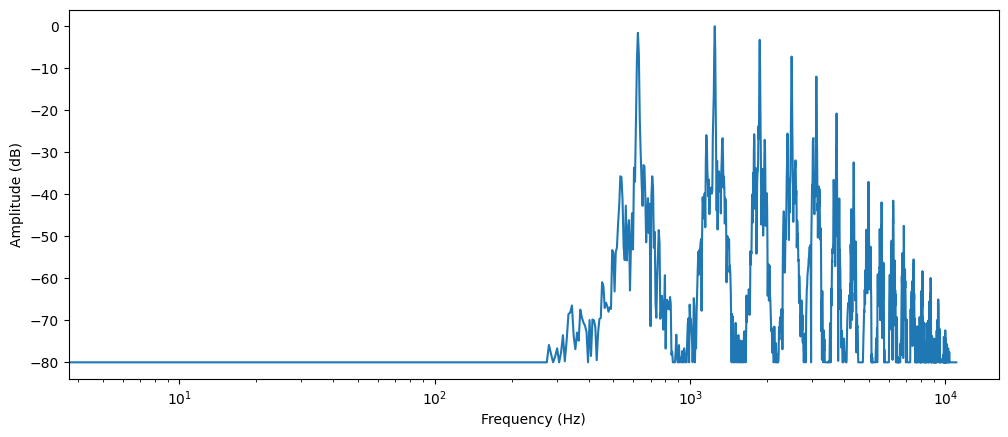

In [3]:
import numpy as np

dft_input = array[:4096]

# calculate the DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

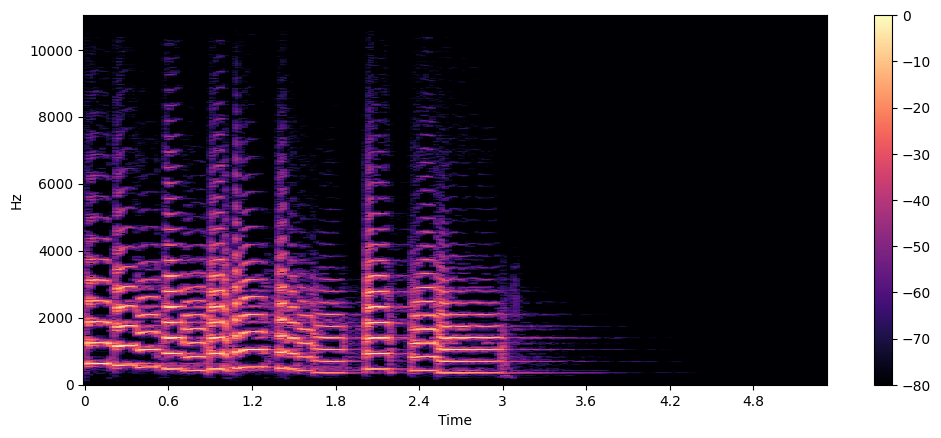

In [4]:
import numpy as np

D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

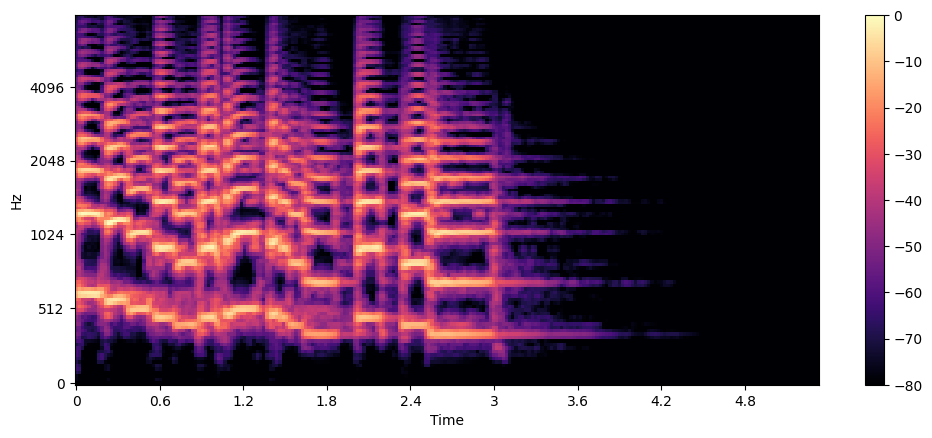

In [5]:
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

In [6]:
# !pip install datasets[audio]

In [7]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [8]:
example = minds[0]
example

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [9]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

In [10]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [11]:
# !pip install kaleido
# !pip install cohere
# !pip install openai
# !pip install tiktoken


In [12]:
# !pip install typing-extensions==4.8.0
# !pip install gradio

In [13]:
import gradio as gr


def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=False)

/usr/local/lib/python3.10/dist-packages/gradio/processing_utils.py:340: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://06ca223696c5acd994.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


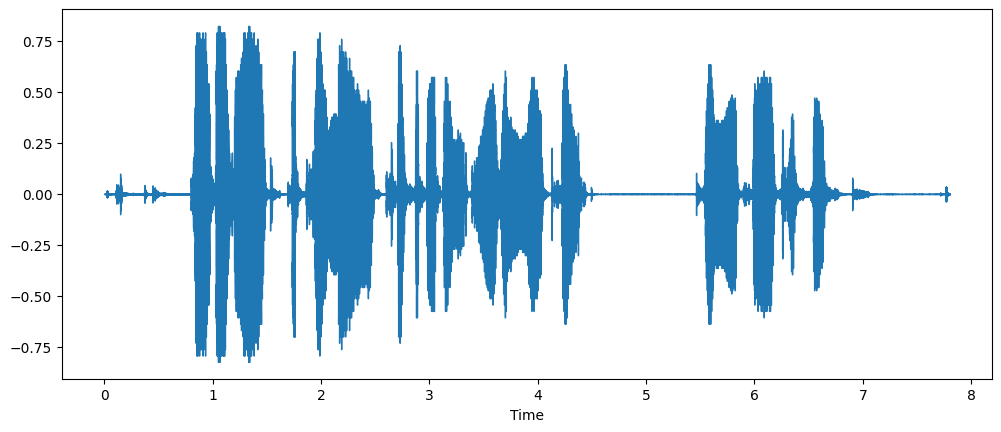

In [14]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

In [15]:
from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [16]:
minds[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

In [17]:
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [18]:
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

In [19]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [20]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [21]:
minds = minds.map(prepare_dataset)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

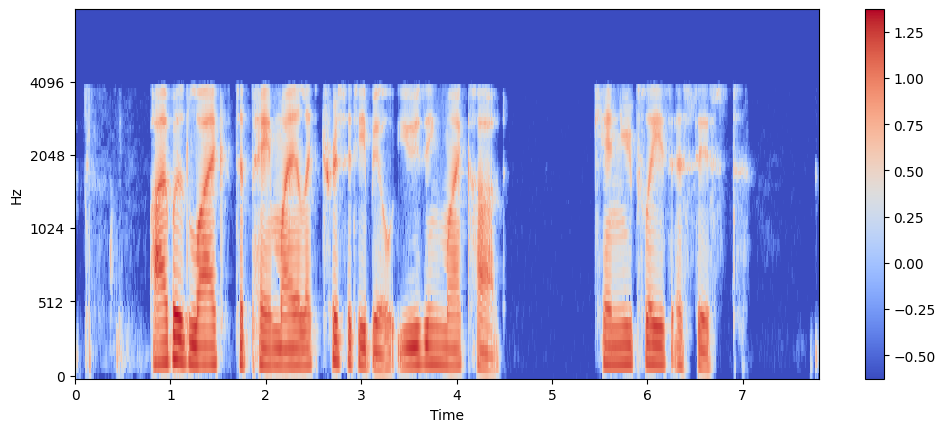

In [22]:
import numpy as np

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

In [23]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")

In [24]:
from huggingface_hub import notebook_login

notebook_login()

In [25]:
gigaspeech = load_dataset("speechcolab/gigaspeech", "xs", streaming=True)

In [26]:
next(iter(gigaspeech["train"]))

{'segment_id': 'YOU0000000315_S0000660',
 'speaker': 'N/A',
 'text': "AS THEY'RE LEAVING <COMMA> CAN KASH PULL ZAHRA ASIDE REALLY QUICKLY <QUESTIONMARK>",
 'audio': {'path': 'xs_chunks_0000/YOU0000000315_S0000660.wav',
  'array': array([0.0005188 , 0.00085449, 0.00012207, ..., 0.00125122, 0.00076294,
         0.00036621]),
  'sampling_rate': 16000},
 'begin_time': 2941.89,
 'end_time': 2945.07,
 'audio_id': 'YOU0000000315',
 'title': 'Return to Vasselheim | Critical Role: VOX MACHINA | Episode 43',
 'url': 'https://www.youtube.com/watch?v=zr2n1fLVasU',
 'source': 2,
 'category': 24,
 'original_full_path': 'audio/youtube/P0004/YOU0000000315.opus'}

In [27]:
gigaspeech_head = gigaspeech["train"].take(2)
list(gigaspeech_head)

[{'segment_id': 'YOU0000000315_S0000660',
  'speaker': 'N/A',
  'text': "AS THEY'RE LEAVING <COMMA> CAN KASH PULL ZAHRA ASIDE REALLY QUICKLY <QUESTIONMARK>",
  'audio': {'path': 'xs_chunks_0000/YOU0000000315_S0000660.wav',
   'array': array([0.0005188 , 0.00085449, 0.00012207, ..., 0.00125122, 0.00076294,
          0.00036621]),
   'sampling_rate': 16000},
  'begin_time': 2941.89,
  'end_time': 2945.07,
  'audio_id': 'YOU0000000315',
  'title': 'Return to Vasselheim | Critical Role: VOX MACHINA | Episode 43',
  'url': 'https://www.youtube.com/watch?v=zr2n1fLVasU',
  'source': 2,
  'category': 24,
  'original_full_path': 'audio/youtube/P0004/YOU0000000315.opus'},
 {'segment_id': 'AUD0000001043_S0000775',
  'speaker': 'N/A',
  'text': 'SIX TOMATOES <PERIOD>',
  'audio': {'path': 'xs_chunks_0000/AUD0000001043_S0000775.wav',
   'array': array([ 1.43432617e-03,  1.37329102e-03,  1.31225586e-03, ...,
          -6.10351562e-05, -1.22070312e-04, -1.83105469e-04]),
   'sampling_rate': 16000},
 